## 3. Алгоритмы предварительной обработки изображений и их реализация

In [1]:
import cv2
import skimage
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Свертка (Convolution)

1. Определение

![](https://upload.wikimedia.org/wikipedia/commons/6/6e/Convolution_of_box_signal_with_itself.gif "conv1")

![](https://upload.wikimedia.org/wikipedia/commons/6/67/Convolution_of_spiky_function_with_box.gif "conv2")

$\textbf{Свёртка, конволюция}$ — операция, которая при применении к двум функциям 
$f(x)$ и $g(x)$ возвращает третью функцию, соответствующую взаимнокорреляционной функции $f(x)$ и $g(-x)$. Смысл - "схожесть" одного сигнала с отраженным другим. Другими словами, имеется система, подается на вход сигнал, выход системы - результат свертки.

В компьютерном зрении часто рассматривают как системы - различные фильтры (выделения краев, медианный фильтр и другие). Адаптивно подстраивая их, мы сможем получать нужные выходные сигналы.

Свойства:

1. $f*g = g*f$
2. $f*(g*h) = (f*g)*h$
3. $(f_{1}+f_{2})*g = f_{1}*g + f_{2}*g$
4. $(\alpha f)*g = f*(\alpha g)$

Одномерный случай свертки

$$ w(t) = \sum\limits_{\tau=0}^{t} g(\tau)^{*} f(t - \tau) $$

где ${*}$ означает комплексное сопряжение.

2. Теория

Идея свертки основывается на дискретном [преобразовании Фурье](https://ru.wikipedia.org/wiki/Преобразование_Фурье) (ДПФ). Можно разложить сигнал на элементарные составляющие - гармонические колебания с разными частотами. В получившийся частотной области исследовать сигнал проще.

Пусть есть функция на интервале длины $L$, мы можем записать эту функцию через сумму синусоид с периодами $L, L/2, L/3, L/4, ...$ + константа. Синусоида описывается магнитудой (относительное положение) и фазой (определяет, как синусоиды выстраиваются относительно друг друга): к примеру, у $f(x)$ = $0.27 * cos(2pi * 0.02x - 1.4)$ $magnitude=0.27, phase=-1.4$. Таким образом, любую функцию можно представить, как ряд магнитуд и фаз. Преобразование Фурье отображает функцию в набор комплексных чисел, представляющих синусоидальные коэффициенты.

Почему используем синусоиды?
- если сложить синусоиды одинаковой частоты (разной магнитуды и фазы), то получим синусоиду той же частоты

Например, если рассматривать линейные системы, то если мы знаем характеристику системы $F$, то можем при любом входном сигнале $G$ получить выходной сигнал $W$ по формуле в частотной области: $W(w) = G(w)F(w)$

ДПФ прямое: $G(w) = \sum\limits_{t=0}^{N-1} g(t) e^{-\frac{2 \pi i}{N} w t}$.

ДПФ обратное: $g(t) = \frac{1}{N} \sum\limits_{w=0}^{N-1} G(w) e^{\frac{2\pi i}{N} w t}$.

Здесь, к примеру, $G(w)$ - это полученный ответ на пропущенную синусоиду частоты $w$ через фильтр (или сигнал) $g(t)$; $N$ - длина сигнала. 
Преобразование Фурье по факту табуляция магнитуды (коэффициент масштаба) и фазы (сдвиг) на каждой частоте.

3. Визуализация в частотной области

Используя формулу Эйлера $e^{j\omega T} = cos(\omega T) + j\cdot sin(\omega T)$, можно определить *вещественную* и *мнимую* составляющие, а также **модуль** и **аргумент** спектральной плотности, которые связаны с вещественной и мнимой частями спектра через формулы теории функции комплексного переменного.

Модуль (магнитуда): $|X(kT)| = \sqrt{Re(X)^2 + Im(X)^2}$

Фаза: $arg(X(kT)) = \arctan{\frac{Im(X)}{Re(X)}}$







Вопрос 1*.

Выведите выражение для одномерной свертки, используя прямое и обратное ДПФ.

Свертка двух функций эквивалентна их умножению в частотном домене, т.е. чтобы получить свертку нужно: сделать преобразование Фурье для каждой функции, перемножить результаты, а затем применить обратное преобразование Фурье.

Учитывая то, что быстрое преобразование Фурье оценивается в $NlogN$ операций, а прямолинейно считая свертку мы сделаем $N^2$ операций, то таким методом мы ускорим вычисление свертки.

Пусть есть два сигнала $f(t)$ и $g(t)$. Вычислим прямое преобразование Фурье для них: \
$G(w) = \sum\limits_{t=0}^{N-1} g(t) e^{-\frac{2 \pi i}{N} w t}$. \
$F(w) = \sum\limits_{t=0}^{N-1} f(t) e^{-\frac{2 \pi i}{N} w t}$. \
Перемножим: $Y(w) = G(w) * F(w)$. \
Вычислим обратное преобразование Фурье: \
$y(t) = \frac{1}{N} \sum\limits_{w=0}^{N-1} Y(w) e^{\frac{2\pi i}{N} w t} = 
\frac{1}{N} \sum\limits_{w=0}^{N-1} G(w) * F(w) e^{\frac{2\pi i}{N} w t} = 
\frac{1}{N} \sum\limits_{w=0}^{N-1} \sum\limits_{m=0}^{N-1} g(m) e^{-\frac{2 \pi i}{N} w t} * F(w) e^{\frac{2\pi i}{N} w t} = 
\sum\limits_{m=0}^{N-1} g(m) * ( \frac{1}{N} \sum\limits_{w=0}^{N-1} F(w) * e^{\frac{2\pi i}{N} w (t - m)}) = \sum\limits_{m=0}^{N-1} g(m) * f(t - m)$$




### Методы фильтрации изображений

Рассмотрим несколько стандартных моделей шума
1. $\textbf{Соль и перец}$ - случайные черные и белые пиксели
2. $\textbf{Импульсный}$ - случайные белые пиксели
3. $\textbf{Гауссов}$ - колебания яркости, распределенные по нормальному закону

Проанализируем часть из них на одномерных массивах

In [11]:
import ipywidgets
from scipy.fftpack import (
    fft, ifft,
    fft2, ifft2,
    fftshift, ifftshift,
)

def viz_signal(
    signal: list,
) -> None:

    # signal
    x = np.array(signal)

    # Forward FFT
    N = 512
    xFFT = fftshift(fft(x, N))
    # Magnitude spectrum
    xA = np.abs(xFFT)
    # Phase spectrum
    xF = np.angle(xFFT)

    # List of signals
    xT = [x, xA, xF, ]
    lst_title = ['Signal', 'Spectrum [db]', 'Phase']

    # Plot results
    fig = plt.figure(figsize=(20, 10), dpi=80)

    for i, sig in enumerate(xT):
        plt.subplot(2, 2, int(2**i))
        plt.ylabel('Level', fontsize=30)
        plt.title(lst_title[i], fontsize=30)
        if i == 0:
            plt.stem(sig, use_line_collection=True, basefmt='C0')
            plt.xlabel('Time samples', fontsize=30)
        else:
            plt.plot(sig)
            plt.xlabel('Freq samples', fontsize=30)
            plt.xlim([0, N - 1])
        plt.grid()

    plt.tight_layout()

#define signal
N = 128
# time vector
t = np.linspace(0, 1, N)
# freq
f1 = 2
signal = np.cos(2*np.pi*f1*t)

@ipywidgets.interact(
    value=ipywidgets.IntSlider(
        min=-10, max=30,
        step=1, value=signal[N - 1],
    ),
    pos=ipywidgets.IntSlider(
        min=0, max=N,
        step=1, value=N - 1,
    ),
)
def play_with_signal(
    value: int,
    pos: int,
) -> None:

    signal[pos] = value

    viz_signal(signal)

interactive(children=(IntSlider(value=1, description='value', max=30, min=-10), IntSlider(value=127, descripti…

Вопрос 2. Можете изменять входные параметры скрипта, выразите свои предположения о шуме, и как это сказывается на спектре сигнала и его фазе. Приведите конкретные примеры.

Сигнал раскладывается на гармонические колебания с разными частотами. 
Спектр сигнала имеет характерную форму: центральный пик ("главная доля") с кучей "боковых долей" в любом направлении от пика. При добавлении шума у боковых долей увеличиваются значения, до этого они были близки к 0.
Значения фазы определяют сдвиг синусоидальных компонент, с шумом сдвиг фазы начинает принимать хаотичные значения с большей амплитудой.



Вопрос 3. Реализуйте шумы типа соль/перец и гаусов шум.

In [12]:
def saltpepper_noise(
    image: np.array,
    proportion: float=0.2,
) -> np.array:

    image_copy = image.copy()

    h, w = image.shape

    n_points = int(proportion * h * w)
    
    xs = np.random.randint(
        low=0,
        high=h,
        size=(n_points, ),
    )
    
    ys = np.random.randint(
        low=0,
        high=w,
        size=(n_points, ),
    )

    image_copy[xs, ys] = np.random.choice(
        a=[0, 255],
        size=(n_points, ),
        p=[0.5, 0.5],
    )
    
    return image_copy

def gaussian_noise(
    image: np.array,
    mean: float=0.04,
    sigma: float=0.07,
) -> np.array:

    noise_image = image / 255. + np.random.normal(mean, sigma, img.shape)
    
    noise_image = (np.clip(noise_image, 0, 1) * 255).astype(np.uint8)
    
    return noise_image

def do_nothing(
    image: np.array,
) -> np.array:

    return image

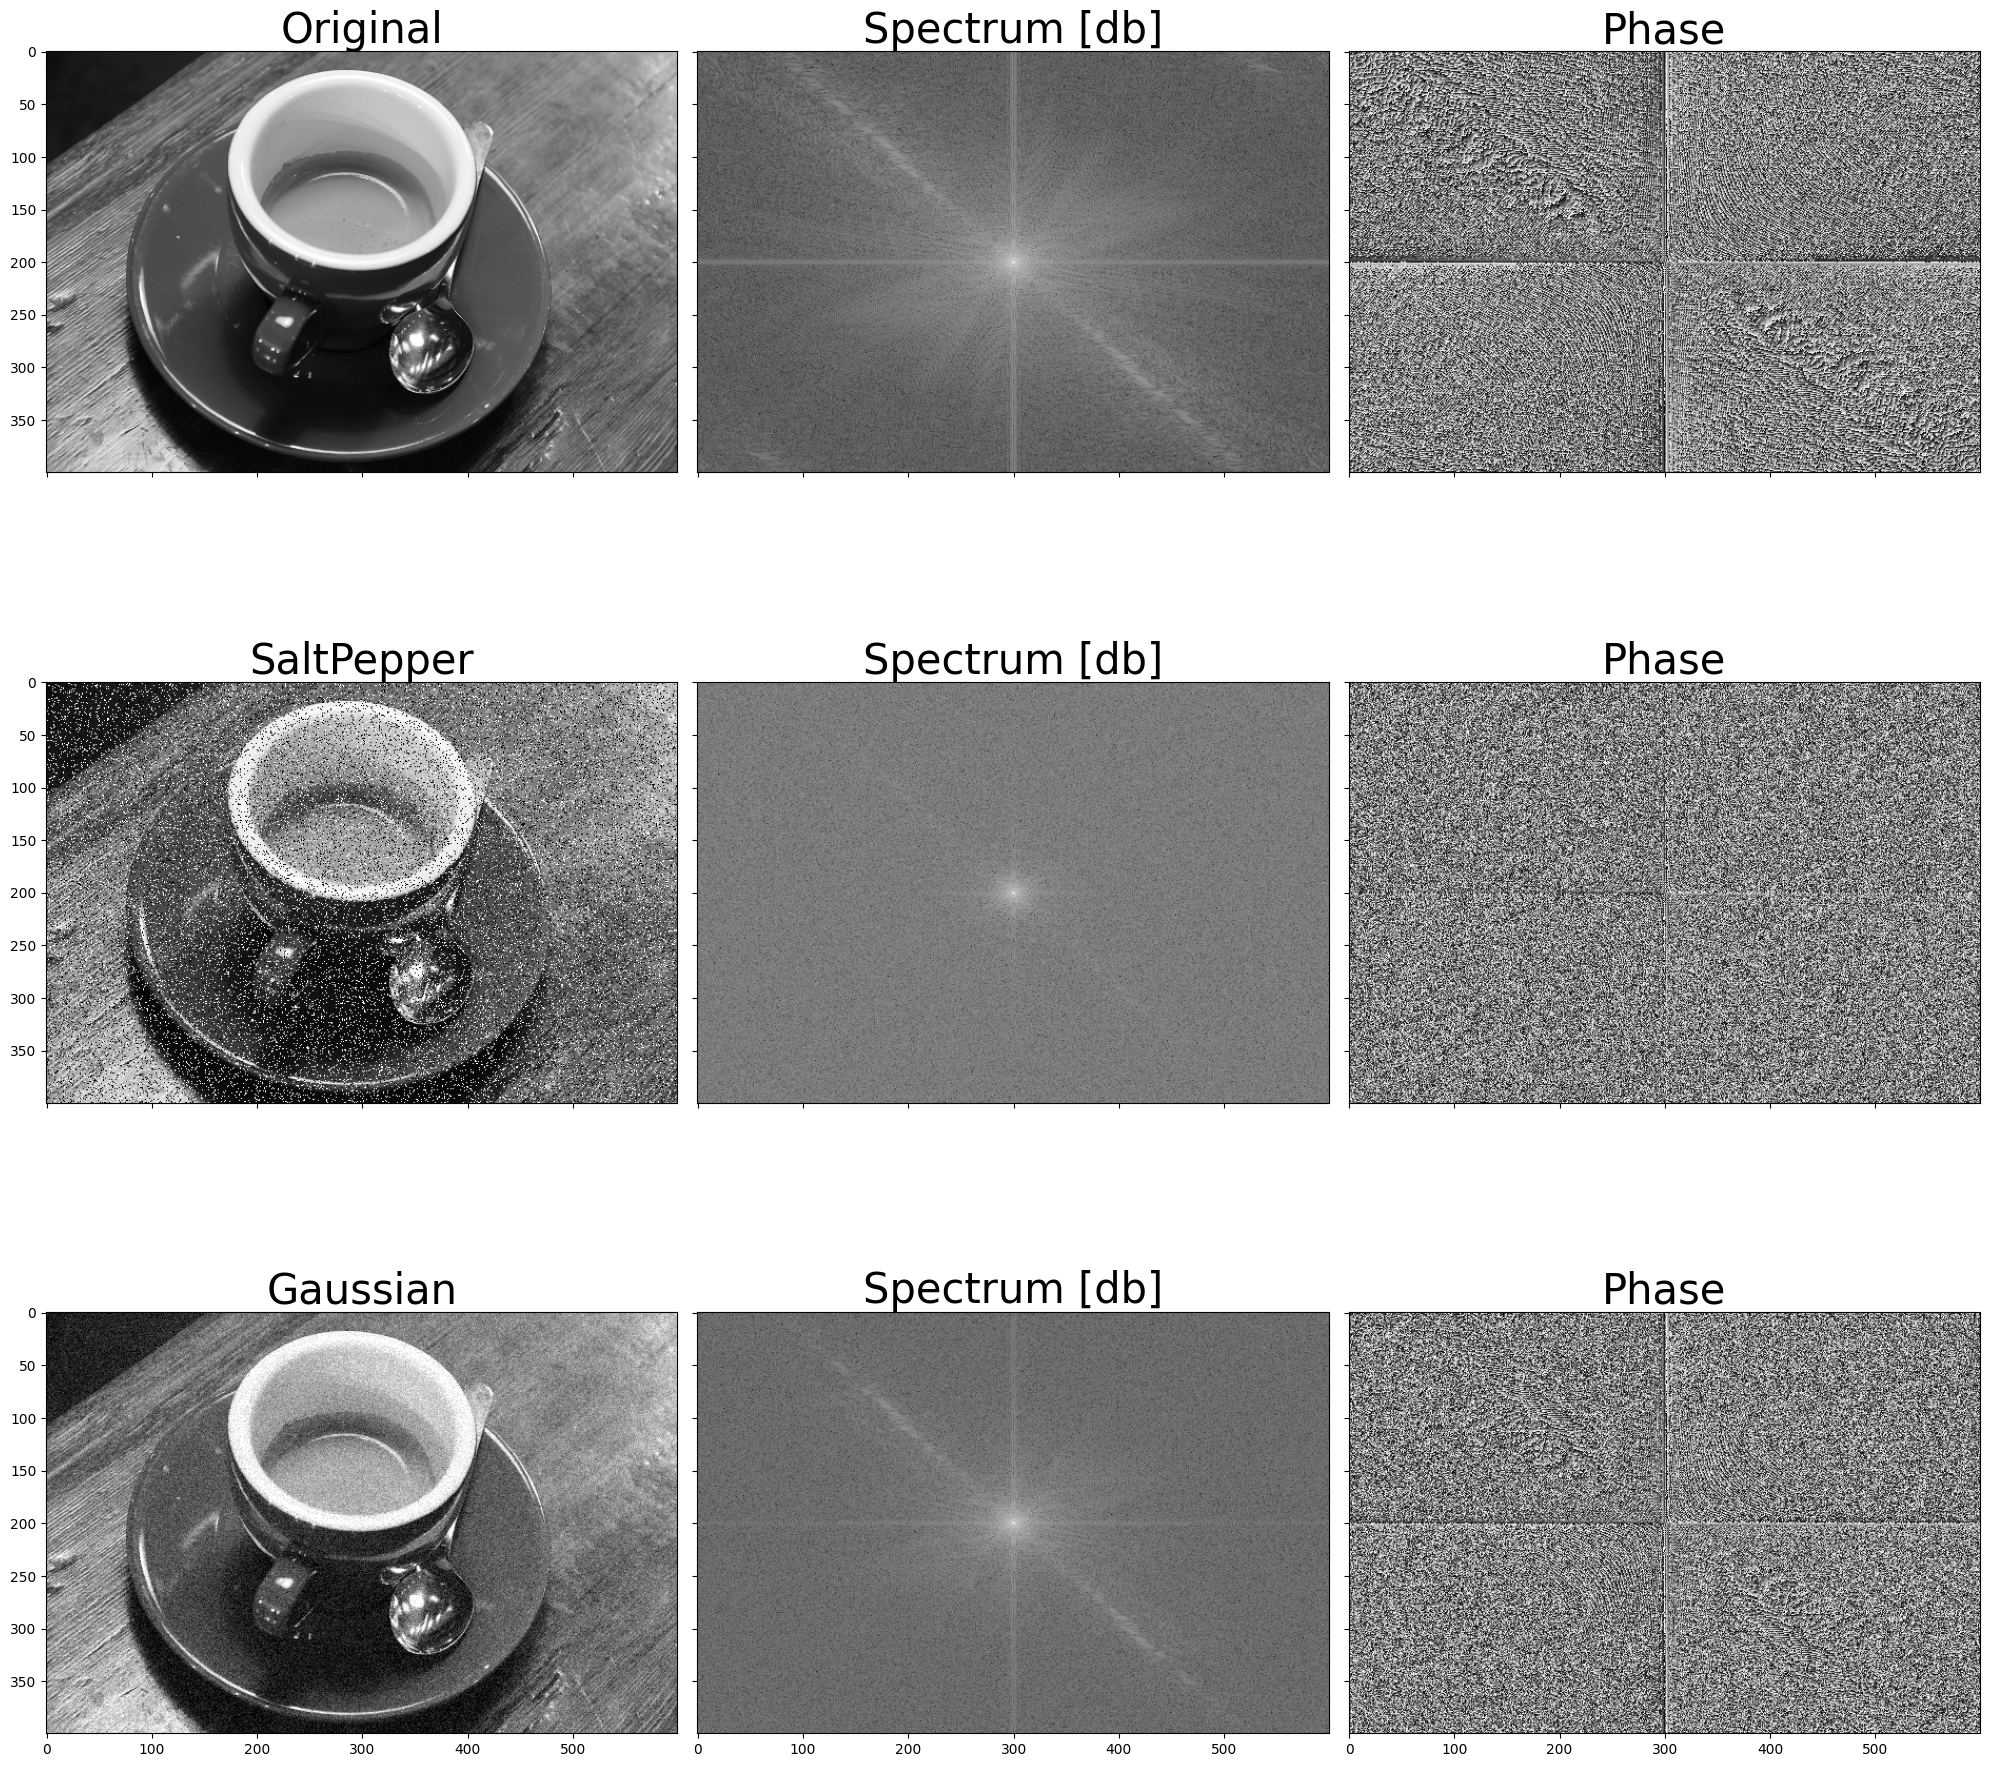

In [32]:
from skimage import data

img = cv2.cvtColor(
    src=data.coffee(),
    code=cv2.COLOR_RGB2GRAY,
)

xT = [do_nothing, saltpepper_noise, gaussian_noise]
lst_title = ['Original', 'SaltPepper', 'Gaussian', ]

# Plot results
fig, axes = plt.subplots(
    nrows=3,
    ncols=len(lst_title),
    sharex=True,
    sharey=True,
    figsize=(20, 20),
    dpi=100,
)

for i in range(len(lst_title)):

    tmp_image = xT[i](img)

    spectrum = fftshift(fft2(tmp_image))

    # Magnitude spectrum
    xA = 20 * np.log(np.abs(spectrum))
    # Phase spectrum
    xF = np.angle(spectrum)

    axes[i][0].imshow(
        tmp_image,
        label=lst_title[i],
        cmap='gray',
    )

    axes[i][0].set_title(lst_title[i], fontsize=30)
    
    axes[i][1].imshow(
        xA,
        cmap='gray',
    )

    axes[i][1].set_title('Spectrum [db]', fontsize=30)

    axes[i][2].imshow(
        xF,
        cmap='gray',
    )

    axes[i][2].set_title('Phase', fontsize=30)

plt.tight_layout()

Вопрос 4. В чем разница шумов на полученных спектрах? Посмотрите также разницу на других фотографиях. Они доступны в переменной data

Без шума получаем симметричное изображения спектра с множеством деталей. \
При salt and pepper все стягивается к середине, так как число белых пикселей становится больше, а часть зануляется черными.
При гауссовском шуме получаем сглаженный спектр ориганала.

### Базовые фильтры

![](http://www.djvu-soft.narod.ru/bookscanlib/cf1.jpg)

![](http://www.djvu-soft.narod.ru/bookscanlib/cf2.jpg)

Рассмотрим линейные фильтры, основанные, конечно же, на конволюции.

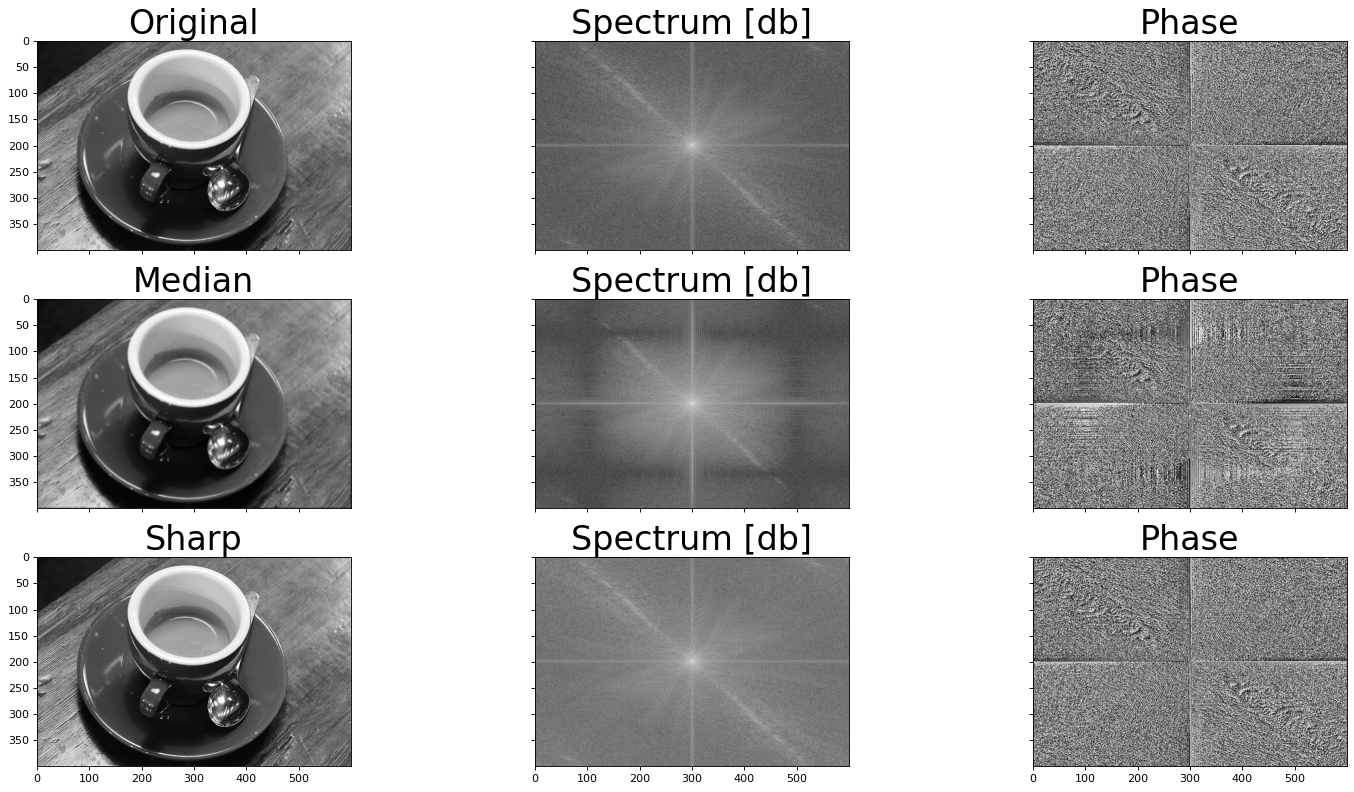

In [48]:
nothing = np.array([
    [1., ],
])

mean = np.array([
    [1, 1, 1, ],
    [1, 1, 1, ],
    [1, 1, 1, ],
]) / 9

sharp = np.array([
    [0, -1, 0, ],
    [-1, 9, -1, ],
    [0, -1, 0, ],
]) / 5

filters = [nothing, mean, sharp, ]
lst_title = ['Original', 'Median', 'Sharp', ]

fig, axes = plt.subplots(
    nrows=3,
    ncols=len(lst_title),
    sharex=True,
    sharey=True,
    figsize=(20, 10),
    dpi=80,
)
for i in range(len(filters)):

    filtered_img = cv2.filter2D(
        src=img,
        kernel=filters[i],
        ddepth=-1, #the same depth as input
        borderType=cv2.BORDER_CONSTANT,
        anchor=(-1, -1), #center of the kernel
        delta=0, #additional data added to
    )

    axes[i][0].imshow(
        filtered_img,
        cmap='gray',
    )
    
    axes[i][0].set_title(lst_title[i], fontsize=30)

    spectrum = fftshift(fft2(filtered_img))
    # Magnitude spectrum
    xA = 20 * np.log(np.abs(spectrum))
    # Phase spectrum
    xF = np.angle(spectrum)

    axes[i][1].imshow(
        xA,
        cmap='gray',
    )

    axes[i][1].set_title('Spectrum [db]', fontsize=30)

    axes[i][2].imshow(
        xF,
        cmap='gray',
    )

    axes[i][2].set_title('Phase', fontsize=30)

plt.tight_layout()

Особенность свертки - ее локальность. Чем больше ядро светки - тем в большей окрестности она охватывает пиксели.

Вопрос 5. Проанализируйте спектр и фазы зашумленных сигналов после применения фильтров. Что изменилось?

В случае медианного фильтра появился темный прямоугольник на спектре, возможно это связано с его нелинейностью.
В случае sharp спектр стал менее контрастным.

Вопрос 6. Реализуйте свою свертку и сравните с реализацией `cv2.filter2D`. 

In [103]:
cat = cv2.cvtColor(
    src=data.chelsea(),
    code=cv2.COLOR_RGB2GRAY,
)
kernel = np.array([[1, 0, 1], [1, 0, 1], [1, 0, 1]])

In [120]:
def get_conv2d(img, kernel):
    H, W = img.shape
    h, w = kernel.shape

    conv_img = np.zeros((H, W))
    img = np.pad(img, ((0, h), (0, w)))

    for i in range(H):
        for j in range(W):
            conv_img[i, j] = np.sum(img[i : i + h, j : j + w] * kernel)
    return conv_img.astype('uint8')

Рассмотрим нелинейные фильтры. Многие из них нелокальны и адаптивны.

1. Медианный фильтр
```python
filtered_img = cv2.medianBlur(
      src=img,
      ksize=(5, 5), #kernel size
)
```
2. Гистограмное выравнивание
```python
filtered_img = cv2.equalizeHist(
      src=img,
)
```
3. Contrast Limited Adaptive Histogram Equalization (CLAHE). Описание [англ](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization#Contrast_Limited_AHE)
```python
clahe = cv2.createCLAHE(
      clipLimit=40.0, # Threshold for contrast limiting
      tileGridSize=(8, 8),  # Grid size
)
filtered_img = clahe.apply(img)
```
4. Билатеральный фильтр. Описание [англ](https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MANDUCHI1/Bilateral_Filtering.html), [рус](https://habr.com/ru/post/273159/)
```python
filtered_img = cv2.bilateralFilter(
      src=img,
      d=9, #Diameter of each pixel neighborhood
      sigmaColor=75,  #Filter sigma in the color space
      sigmaSpace=75, #Filter sigma in the coordinate space
      borderType=cv2.BORDER_CONSTANT,
)
```

Разберем подробнее Гистограмное Выравнивание.

Рассмотрим изображение, значения пикселей которого ограничены только определенным диапазоном значений. Например, на более ярком изображении все пиксели будут ограничены высокими значениями. Но хорошее изображение будет содержать пиксели из всех областей изображения. Поэтому вам нужно растянуть эту гистограмму до обоих концов, и это то, что делает выравнивание гистограммы (простыми словами). Обычно это улучшает контрастность изображения.

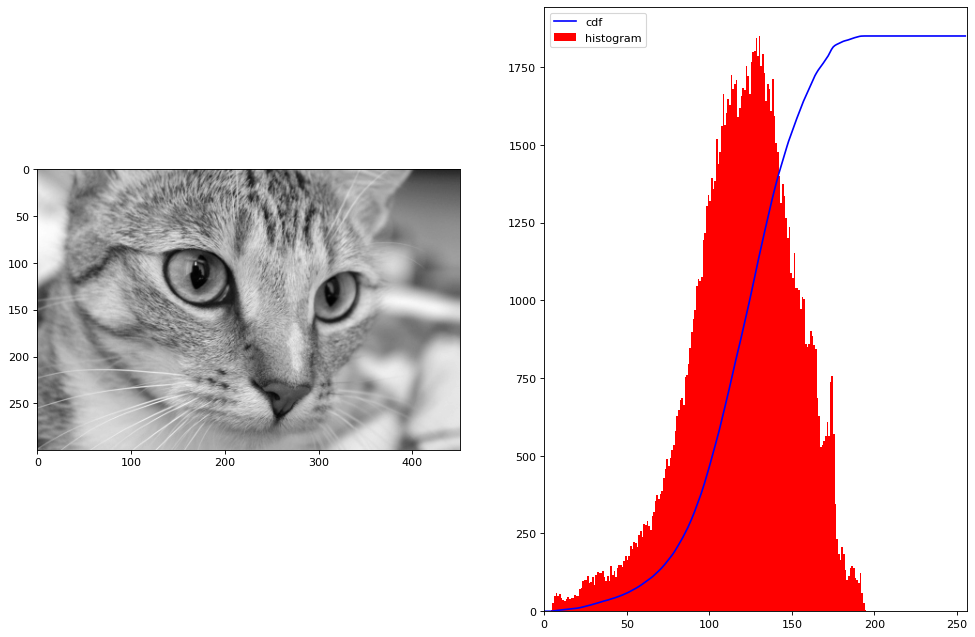

In [ ]:
img = cv2.cvtColor(
    src=data.cat(),
    code=cv2.COLOR_RGB2GRAY,
)

def plot_hist(
    img: np.array,
) -> None:

    fig, axes = plt.subplots(
        ncols=2,
        figsize=(15, 10),
        dpi=80,
    )

    axes[0].imshow(
        img,
        cmap='gray',
    )

    hist, bins = np.histogram(
        a=img.flatten(),
        bins=256,
        range=[0,256],
    )
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()
    axes[1].plot(
        cdf_normalized,
        color='b',
    )
    axes[1].hist(
        x=img.flatten(),
        bins=256,
        range=[0,256],
        color='r',
    )
    axes[1].set_xlim([0,256])
    axes[1].legend(
        ('cdf','histogram'),
        loc='upper left',
    )

def plot_unhist(
    img: np.array,
) -> None:

    hist, bins = np.histogram(
        a=img.flatten(),
        bins=256,
        range=[0,256],
    )
    cdf = hist.cumsum()

    cdf_m = np.ma.masked_equal(
        x=cdf,
        value=0,
    )
    cdf_m = (cdf_m - cdf_m.min())/(cdf_m.max() - cdf_m.min()) * 255

    cdf = np.ma.filled(
        a=cdf_m,
        fill_value=0,
    )

    cdf = cdf.astype(np.uint8)

    img2 = cdf[img]

    plot_hist(img2)

plot_hist(img)

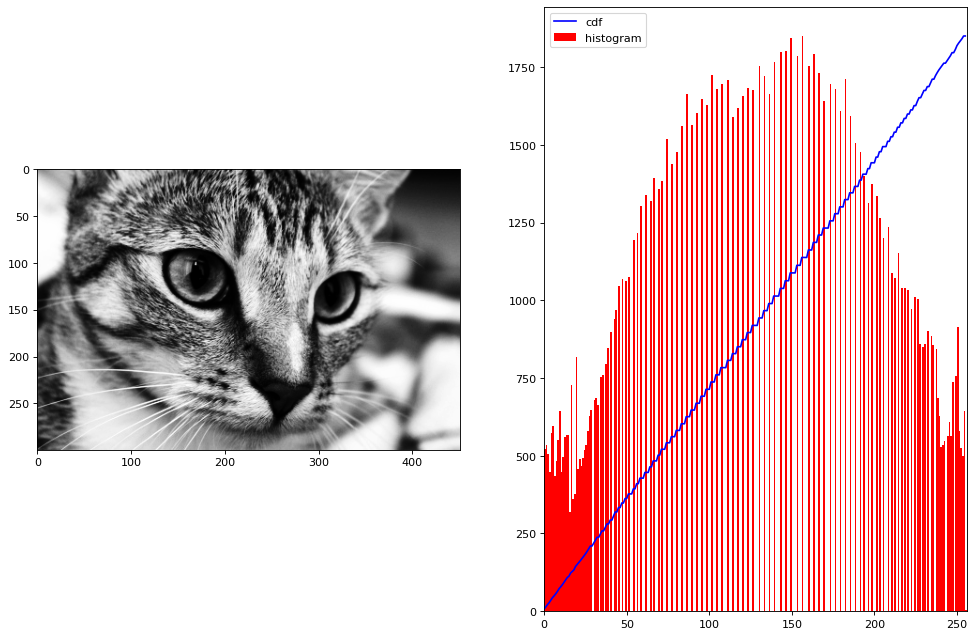

In [ ]:
plot_unhist(img)

In [ ]:
!wget 'https://i2.wp.com/rosphoto.com/resources/images/postfoto686/ori/2.jpg' -O image.jpg

--2022-02-16 13:27:08--  https://i2.wp.com/rosphoto.com/resources/images/postfoto686/ori/2.jpg
Resolving i2.wp.com (i2.wp.com)... 192.0.77.2
Connecting to i2.wp.com (i2.wp.com)|192.0.77.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65931 (64K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  64.39K  --.-KB/s    in 0.04s   

2022-02-16 13:27:10 (1.50 MB/s) - ‘image.jpg’ saved [65931/65931]



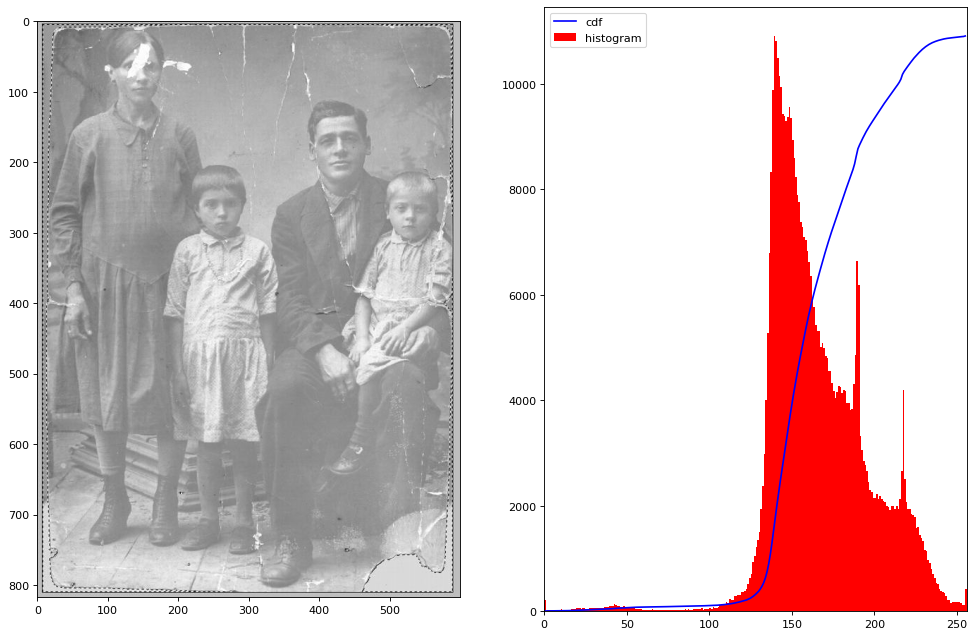

In [ ]:
img = cv2.cvtColor(
    src=cv2.imread('image.jpg'),
    code=cv2.COLOR_RGB2GRAY,
)

plot_hist(img)

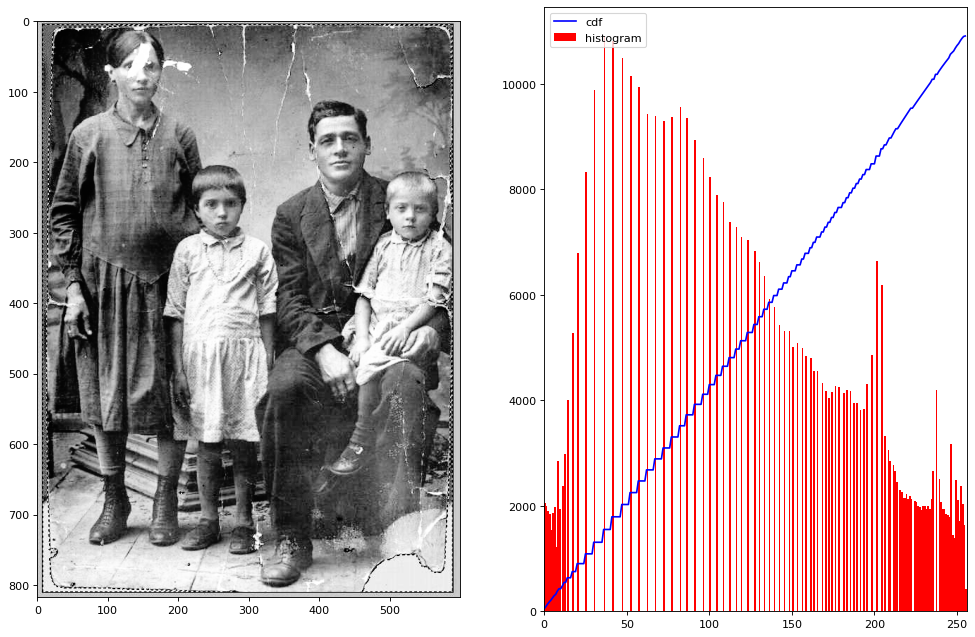

In [ ]:
plot_unhist(img)

Вопрос 7. Примените адаптивное гистограммное выравнивание CLAHE, сравните результат с тем, что получалось при обычном гистограммном выравнивании.

In [ ]:
#your code here

### Оценка качества улучшения фильтрации

$X[i, j]$ - входной сигнал (шумный), $\hat{X}[i, j]$ - входной сигнал (сглаженный)

1. $\text{MSE}(X, \hat{X}) = \frac{1}{NM}\sum\limits_{i, j}\left(X[i, j] - \hat{X}[i, j]\right)^{2}$

2. $\text{PSNR}(X, \hat{X}) = 20\log\frac{\max(\hat{X})}{\sqrt{MSE(X, \hat{X})}}$

3. $\text{SSIM}(X, \hat{X}) = \left[ l(X, \hat{X})^\alpha \cdot c(X, \hat{X})^\beta \cdot s(X, \hat{X})^\gamma \right]$

Подробнее [SSIM](https://en.wikipedia.org/wiki/Structural_similarity)

Вопрос 8. Посчитайте PSNR между оригинальным изображением и зашумленным соль/перец, размытым гаусовским шумом, гистограмно-выравненым, с использованием CLAHE. Есть ли существенная разница? Почему?

In [ ]:
#your code here